In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_98585/3827359723.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [49]:
ds_version = "RTK"
annotations_file = "GT_RTK.csv"
pred_file_type = "V1_0_merged_lmh-crop_type_prediction-RTK_GT-20240816_071611.csv"
pred_file_asphalt = "V1_0_merged_lmh-crop_quality_asphalt_prediction-RTK_GT_asphalt-20240816_071625.csv"
pred_file_paved = "V1_0_merged_lmh-crop_quality_paved_prediction-RTK_GT_paved-20240816_071632.csv"
pred_file_unpaved = "V1_0_merged_lmh-crop_quality_unpaved_prediction-RTK_GT_unpaved-20240816_071639.csv"

root_data_path = os.path.join("..", "data", ds_version) # TODO: prediction folder, see prediction file
data_path = os.path.join(root_data_path, "metadata") # TODO: prediction folder, see prediction file

In [50]:
pred = pd.read_csv(os.path.join(data_path, pred_file_type))
pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred"}, inplace=True)

type_pred = pred[["image_id", "Prediction", "type_pred", "is_in_validation"]]
type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
idx = type_pred.groupby("image_id")["class_prob"].idxmax()
type_pred = type_pred.loc[idx]

asphalt_pred = pd.read_csv(os.path.join(data_path, pred_file_asphalt))
paved_pred = pd.read_csv(os.path.join(data_path, pred_file_paved))
unpaved_pred = pd.read_csv(os.path.join(data_path, pred_file_unpaved))

quality_pred = pd.concat([
    asphalt_pred,
    paved_pred,
    unpaved_pred,
], ignore_index=True)
quality_pred.rename(columns={"Image": "image_id",  "Level_0": "quality_pred"}, inplace=True)
quality_pred = quality_pred[["image_id", "Prediction", "quality_pred", "is_in_validation"]]
quality_pred.rename(columns={"Prediction": "quality_float_pred"}, inplace=True)

pred = quality_pred.set_index("image_id").join(type_pred.set_index("image_id"), lsuffix="_quality", rsuffix="_type")

/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_98585/1635965078.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)


In [51]:
pred

,quality_float_pred,quality_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type
image_id,,,,,,
3_000000000,1.467606,excellent,0,0.969637,asphalt-concrete,0
3_000000001,1.549352,good,0,0.943448,asphalt-concrete,0
3_000000002,1.547387,good,0,0.892990,asphalt-concrete,0
3_000000003,1.564837,good,0,0.953924,asphalt-concrete,0
3_000000004,1.549906,good,0,0.912752,asphalt-concrete,0
...,...,...,...,...,...,...
7_000000791,2.606409,intermediate,0,0.985968,unpaved,0
7_000000792,2.642468,intermediate,0,0.997192,unpaved,0
7_000000793,2.171345,outside,0,0.982643,unpaved,0


In [52]:
annot = pd.read_csv(os.path.join(data_path, annotations_file))
annot["quality_float_true"] = annot["quality_true"].map({"good": 2, "regular": 3, "bad": 4,})

In [53]:
annot

,image_id,type_true,quality_true,quality_float_true
0,3_000000000,asphalt,bad,4
1,3_000000001,asphalt,bad,4
2,3_000000002,asphalt,bad,4
3,3_000000003,asphalt,bad,4
4,3_000000004,asphalt,bad,4
...,...,...,...,...
6292,7_000000791,unpaved,regular,3
6293,7_000000792,unpaved,regular,3
6294,7_000000793,unpaved,regular,3
6295,7_000000794,unpaved,regular,3


In [54]:
df = pred.join(
    annot[["image_id", "type_true", "quality_true", "quality_float_true"]].set_index("image_id"), how="left")

In [55]:
import numpy as np
np.corrcoef(df.quality_float_true, df.quality_float_pred)

# distinguish by type?

# only type prediction true

array([[1.        , 0.61362449],
       [0.61362449, 1.        ]])

In [56]:
print(np.corrcoef(df[df.type_true == "asphalt"].quality_float_true, df[df.type_true == "asphalt"].quality_float_pred))
print(np.corrcoef(df[df.type_true == "paved"].quality_float_true, df[df.type_true == "paved"].quality_float_pred))
print(np.corrcoef(df[df.type_true == "unpaved"].quality_float_true, df[df.type_true == "unpaved"].quality_float_pred))

[[1.         0.76937302]
 [0.76937302 1.        ]]
[[1.         0.38114702]
 [0.38114702 1.        ]]
[[1.         0.23344291]
 [0.23344291 1.        ]]


In [95]:
from scipy.stats import pearsonr, spearmanr

classes = df['type_true'].unique()
quality_corr_list = []

for cls in classes:
    class_df = df[df['type_true'] == cls]
    pearson_corr, pearson_p_value = pearsonr(class_df.quality_float_true, class_df.quality_float_pred)
    spearman_corr, spearman_p_value = spearmanr(class_df.quality_float_true, class_df.quality_float_pred)
    
    quality_corr_list.append({
        'Class': cls,
        'Pearson_Coefficient': pearson_corr,
        'Pearson_p_value': pearson_p_value,
        'Spearman_Coefficient': spearman_corr,
        'Spearman_p_value': spearman_p_value
    })

# Berechne die Korrelationskoeffizienten und p-Werte für alle Daten zusammen
pearson_corr, pearson_p_value = pearsonr(df.quality_float_true, df.quality_float_pred)
spearman_corr, spearman_p_value = spearmanr(df.quality_float_true, df.quality_float_pred)

# Füge die Gesamtwerte zur Tabelle hinzu
quality_corr_list.append({
    'Class': 'Overall',
    'Pearson_Coefficient': pearson_corr,
    'Pearson_p_value': pearson_p_value,
    'Spearman_Coefficient': spearman_corr,
    'Spearman_p_value': spearman_p_value
})

quality_corr_results = pd.DataFrame(quality_corr_list)


# Ausgabe der Ergebnisse
print(quality_corr_results)

     Class  Pearson_Coefficient  Pearson_p_value  Spearman_Coefficient  \
0  asphalt             0.769373     0.000000e+00              0.714299   
1    paved             0.381147     2.106485e-57              0.422293   
2  unpaved             0.233443     1.202416e-18              0.220707   
3  Overall             0.613624     0.000000e+00              0.621902   

   Spearman_p_value  
0      0.000000e+00  
1      2.293801e-71  
2      8.723150e-17  
3      0.000000e+00  


In [87]:
# from sklearn.metrics import classification_report

# report = classification_report(df['type_true'], df['type_pred'].replace({'asphalt-concrete': 'asphalt', 'paving_stones-sett': 'paved'}))
# print(report)

              precision    recall  f1-score   support

     asphalt       0.83      0.91      0.87      3281
       paved       1.00      0.51      0.68      1627
     unpaved       0.73      0.98      0.84      1389

    accuracy                           0.82      6297
   macro avg       0.85      0.80      0.80      6297
weighted avg       0.85      0.82      0.81      6297



In [57]:
df

,quality_float_pred,quality_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_true,quality_float_true
image_id,,,,,,,,,
3_000000000,1.467606,excellent,0,0.969637,asphalt-concrete,0,asphalt,bad,4
3_000000001,1.549352,good,0,0.943448,asphalt-concrete,0,asphalt,bad,4
3_000000002,1.547387,good,0,0.892990,asphalt-concrete,0,asphalt,bad,4
3_000000003,1.564837,good,0,0.953924,asphalt-concrete,0,asphalt,bad,4
3_000000004,1.549906,good,0,0.912752,asphalt-concrete,0,asphalt,bad,4
...,...,...,...,...,...,...,...,...,...
7_000000791,2.606409,intermediate,0,0.985968,unpaved,0,unpaved,regular,3
7_000000792,2.642468,intermediate,0,0.997192,unpaved,0,unpaved,regular,3
7_000000793,2.171345,outside,0,0.982643,unpaved,0,unpaved,regular,3


In [58]:
df.groupby(["type_true", "quality_true"]).size()

type_true  quality_true
asphalt    bad              464
           good            1978
           regular          839
paved      bad              124
           good            1179
           regular          324
unpaved    bad              593
           regular          796
dtype: int64

In [72]:
df.groupby(["type_true", "quality_true", "type_pred", "quality_pred"]).size()

type_true  quality_true  type_pred           quality_pred
asphalt    bad           asphalt-concrete    bad               24
                                             excellent          2
                                             good             158
                                             intermediate     272
                         unpaved             good               5
                                             intermediate       3
           good          asphalt-concrete    excellent        676
                                             good            1132
                                             intermediate       7
                         unpaved             excellent         56
                                             good             105
                                             intermediate       2
           regular       asphalt-concrete    excellent         18
                                             good             603
                  

In [59]:
df.shape

(6297, 9)

## Surface type

Text(58.222222222222214, 0.5, 'true type')

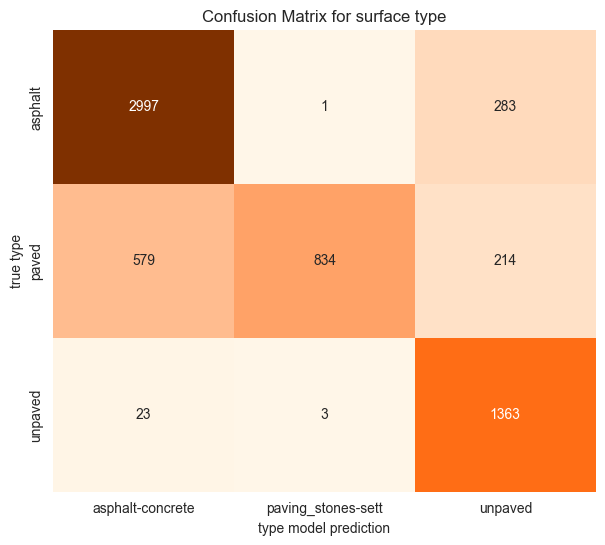

In [90]:
# confusion matrix for all model surface types
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# labels_type_true = df.type_true.unique()
# labels_type_pred = df.type_pred.unique()
labels = ['asphalt', 'asphalt-concrete', 'paving_stones-sett', 'paved', 'unpaved']

# cm = confusion_matrix(df[~((df.type_true == "paved") & (df.quality_true == "good"))].type_true, df[~((df.type_true == "paved") & (df.quality_true == "good"))].type_pred, labels=labels)
# cm = confusion_matrix(df[((df.type_true == "paved") & (df.quality_true == "good"))].type_true, df[((df.type_true == "paved") & (df.quality_true == "good"))].type_pred, labels=labels)
cm = confusion_matrix(df.type_true, df.type_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['asphalt-concrete', 'paving_stones-sett', 'unpaved']]
cm_df = cm_df.loc[['asphalt', 'paved', 'unpaved']]
# plt.figure()
# sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
#             xticklabels=['asphalt', 'concrete', 'paving_stones', 'sett', 'unpaved'],
#             yticklabels=['asphalt', 'paved', 'unpaved'])
# plt.title(f"Confusion Matrix for surface type")
# plt.xlabel("type model prediction")
# plt.ylabel("true type")
fig, axes = plt.subplots(1, 1, figsize=(7, 6))

# Confusion Matrix für Surface Type
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['asphalt-concrete', 'paving_stones-sett', 'unpaved'],
            yticklabels=['asphalt', 'paved', 'unpaved'],
            ax=axes)
axes.set_title(f"Confusion Matrix for surface type")
axes.set_xlabel("type model prediction")
axes.set_ylabel("true type")

In [84]:
overall_accuracy = cm_df.values.trace() / cm_df.values.sum()

class_precision = cm_df.rename(columns={'asphalt-concrete': 'asphalt', 'paving_stones-sett': 'paved'}).apply(lambda x: x[x.name] / x.sum(), axis=1)

print("Recall per class:")
print(class_precision)

print(f"\nAccuracy: {overall_accuracy:.2f}")


Recall per class:
asphalt    0.913441
paved      0.512600
unpaved    0.981281
dtype: float64

Accuracy: 0.82


## Surface Quality

Text(58.222222222222214, 0.5, 'true quality')

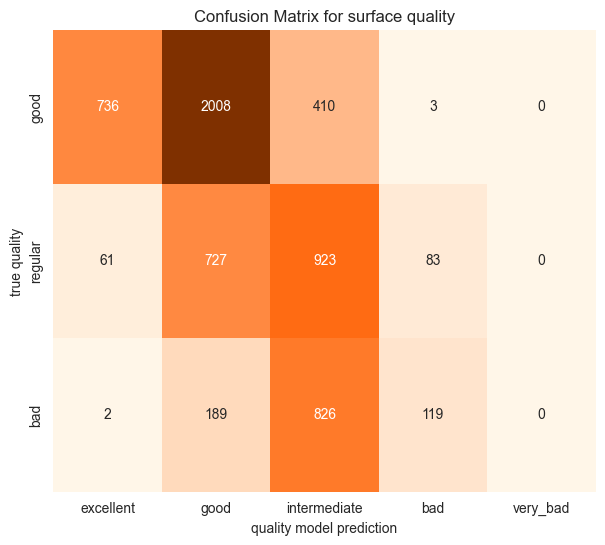

In [62]:
# # confusion matrix for all model surface types
# cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# # labels_type_true = df.type_true.unique()
# # labels_type_pred = df.type_pred.unique()
# labels = ['excellent', 'good', 'intermediate', 'regular', 'bad', 'very_bad']

# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# cm = confusion_matrix(df.quality_true, df.quality_pred, labels=labels)
# cm_df = pd.DataFrame(cm, index=labels, columns=labels)
# cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
# cm_df = cm_df.loc[['good', 'regular', 'bad']]
# sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
#             xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
#             yticklabels=['good', 'regular', 'bad'],
#             ax=axes[0])
# axes[0].set_title(f"Confusion Matrix for surface quality")
# axes[0].set_xlabel("quality model prediction")
# axes[0].set_ylabel("true quality")

# confusion matrix for all model surface types
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# labels_type_true = df.type_true.unique()
# labels_type_pred = df.type_pred.unique()
labels = ['excellent', 'good', 'intermediate', 'regular', 'bad', 'very_bad']

fig, axes = plt.subplots(1, 1, figsize=(7, 6))

cm = confusion_matrix(df.quality_true, df.quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df.loc[['good', 'regular', 'bad']]
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes)
axes.set_title(f"Confusion Matrix for surface quality")
axes.set_xlabel("quality model prediction")
axes.set_ylabel("true quality")

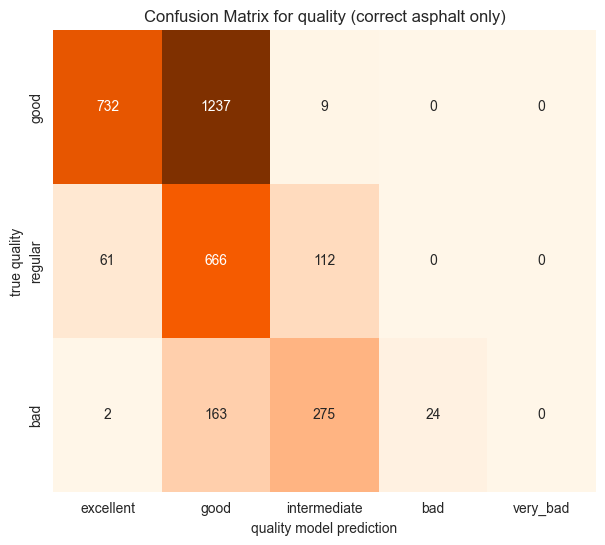

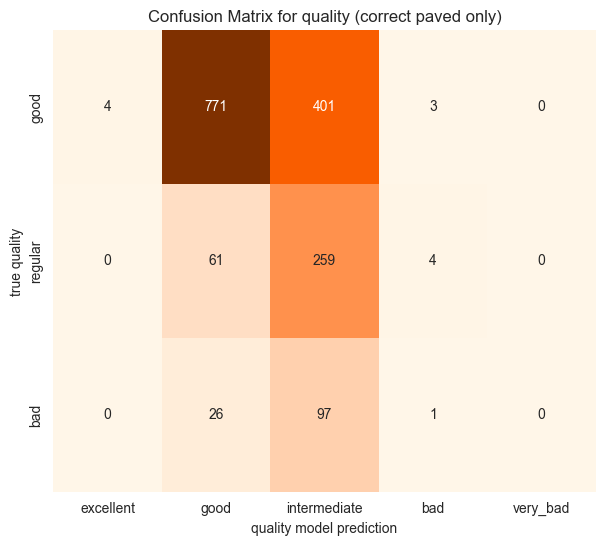

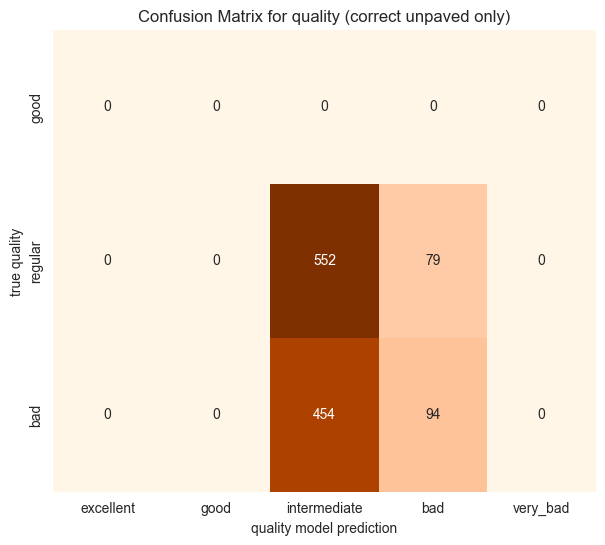

In [63]:
# confusion matrix for all model surface types
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# labels_type_true = df.type_true.unique()
# labels_type_pred = df.type_pred.unique()
labels = ['excellent', 'good', 'intermediate', 'regular', 'bad', 'very_bad']

fig, axes = plt.subplots(1, 1, figsize=(7, 6))

cm = confusion_matrix(df[(df.type_true == 'asphalt')].quality_true, df[(df.type_true == 'asphalt')].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes)
axes.set_title(f"Confusion Matrix for quality (correct asphalt only)")
axes.set_xlabel("quality model prediction")
axes.set_ylabel("true quality")
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(7, 6))

cm = confusion_matrix(df[(df.type_true == 'paved')].quality_true, df[(df.type_true == 'paved')].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes)
axes.set_title(f"Confusion Matrix for quality (correct paved only)")
axes.set_xlabel("quality model prediction")
axes.set_ylabel("true quality")
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(7, 6))

cm = confusion_matrix(df[(df.type_true == 'unpaved')].quality_true, df[(df.type_true == 'unpaved')].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes)
axes.set_title(f"Confusion Matrix for quality (correct unpaved only)")
axes.set_xlabel("quality model prediction")
axes.set_ylabel("true quality")
plt.show()

In [66]:
df[(df.type_true == 'unpaved') & (df.quality_float_pred <= 2.5)].shape

(210, 9)

## Measures for quality by surface type

In [25]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float),
    "mae": mean_absolute_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

In [26]:
gm_surface = pd.DataFrame()
for surface in df.type_true.unique():
    df_ = df[df.type_true == surface]
    gm = compute_measures_float(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,paved,unpaved
accuracy,0.43,0.46,0.26
correlation,0.69,0.33,0.15
r_square,-0.42,-0.56,-4.23
mse,0.75,0.59,1.28
mae,0.70,0.62,0.98
rmse,0.87,0.77,1.13


## compare float values

In [67]:
df_wo_outliers = df[(df["quality_float_pred"] >= 0) & (df["quality_float_pred"] <= 6)]

In [68]:
df_wo_outliers.shape

(6297, 9)

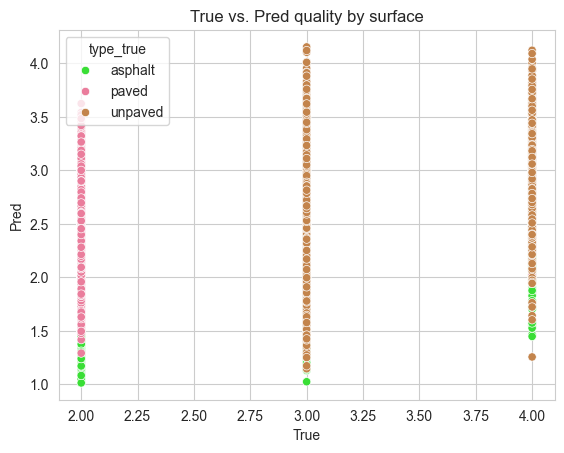

In [69]:
# Plot
np.random.seed(5)
colors = {surface_type: np.random.rand(3,) for surface_type in df.type_true.unique()}

sns.scatterplot(data=df_wo_outliers, x="quality_float_true", y="quality_float_pred", hue="type_true", palette=colors, legend="full")
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('True vs. Pred quality by surface')
plt.show()


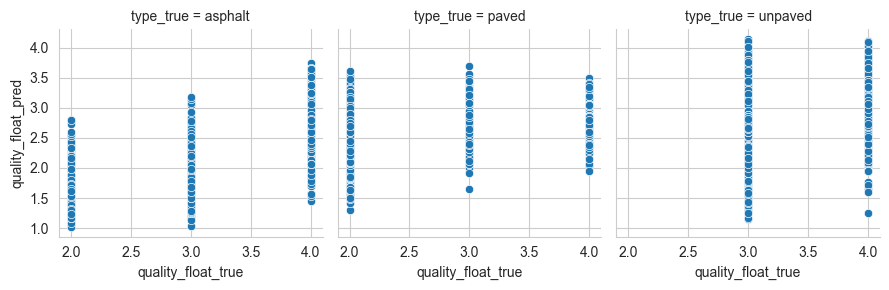

In [70]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(df_wo_outliers, col="type_true", col_wrap=3)

# Map scatter plot for each surface type
g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

plt.show()

#### Hom much do the deviate?

In [80]:
df_valid_quality.loc[:,"deviation"] = df_valid_quality.quality_float_true - df_valid_quality.quality_float_pred

**Overall**

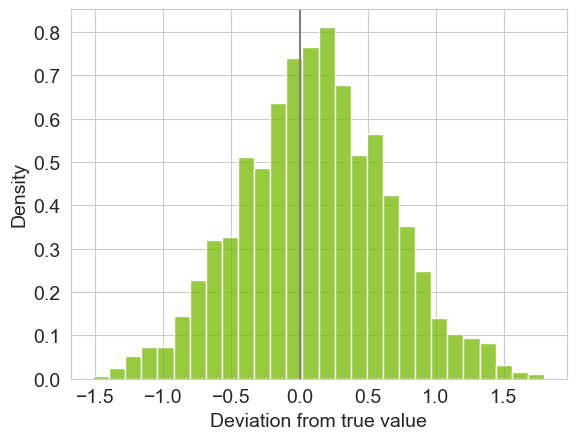

In [182]:
sns.histplot(df_valid_quality, color='#76B900', stat="density", x="deviation")
plt.xlabel("Deviation from true value")
plt.axvline(x=0, color="grey")
plt.savefig("deviation_hist_quality_V1_0.png", transparent=True)
plt.show()


In [160]:
np.mean(df_valid_quality.deviation)

0.1149677615464645

In [158]:
np.std(df_valid_quality.deviation)


0.5403729757753959

In [171]:
(abs(df_valid_quality.deviation) >= 1).value_counts()

deviation
False    1515
True      120
Name: count, dtype: int64

In [173]:
120/len(df_valid_quality)

0.07339449541284404

**by surface**

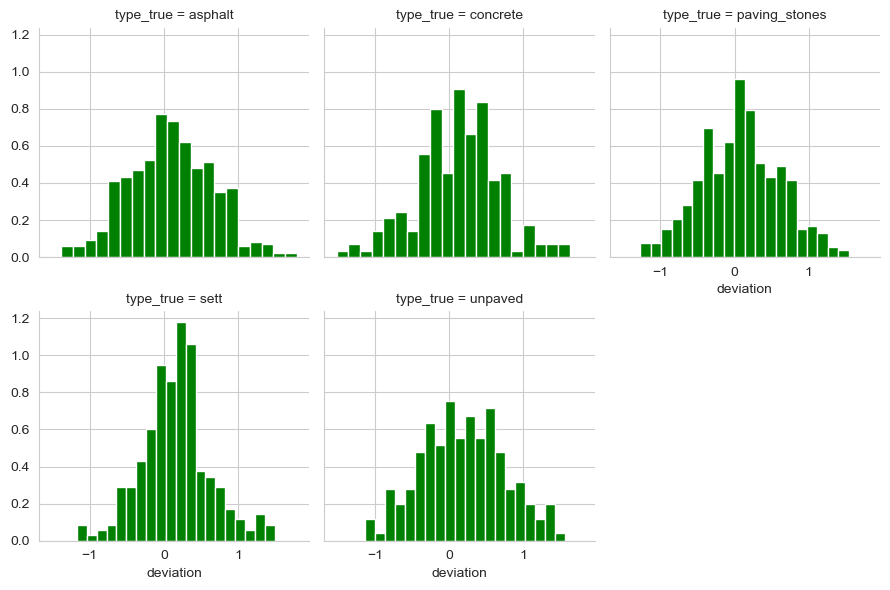

In [82]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map histogram for deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

## compare classes

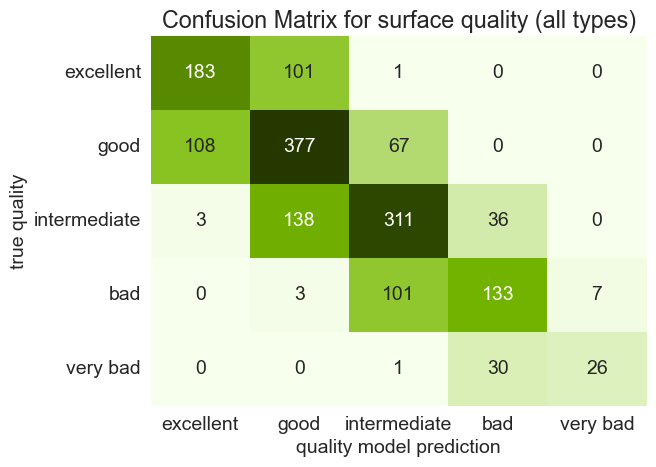

In [185]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_valid_quality.quality_true, df_valid_quality.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

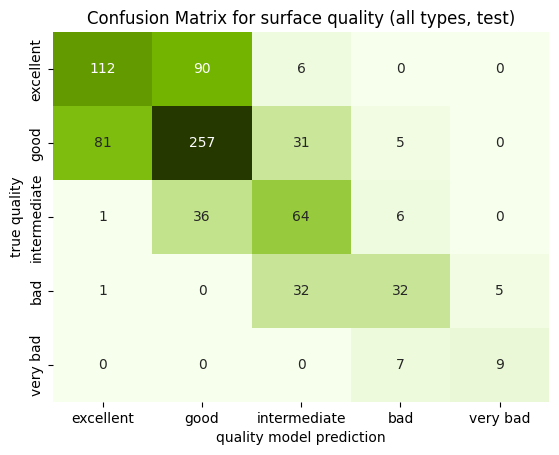

In [23]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_test.quality_true, df_test.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types, test)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0_test.png", transparent=True, bbox_inches='tight')
plt.show()

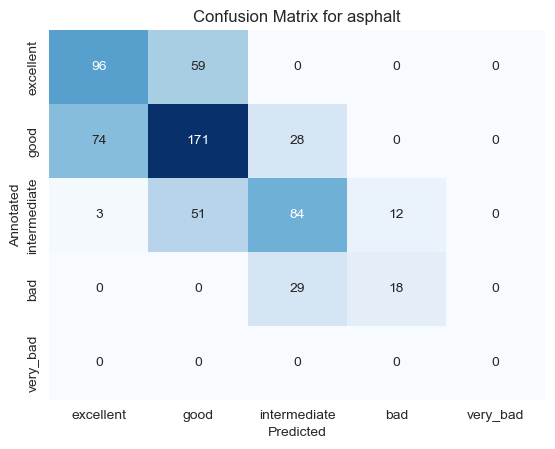

<Figure size 640x480 with 0 Axes>

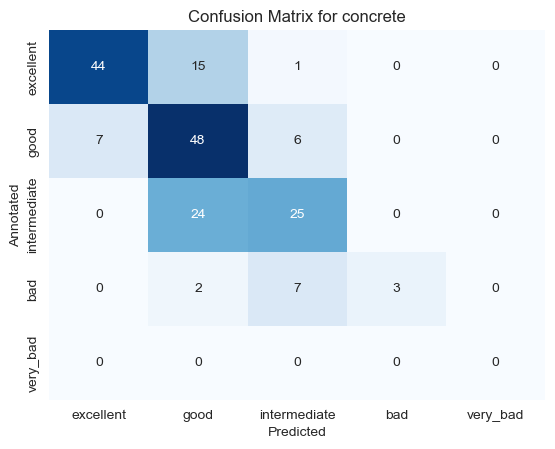

<Figure size 640x480 with 0 Axes>

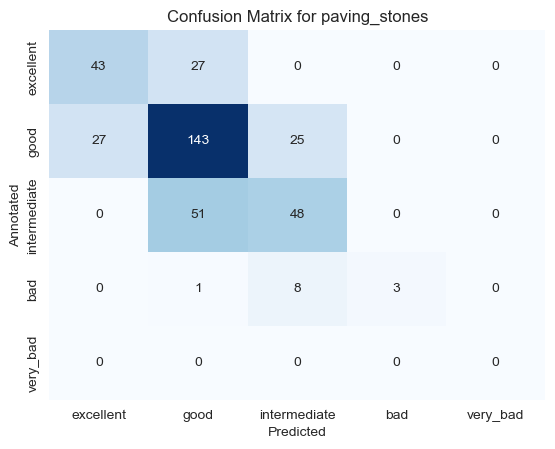

<Figure size 640x480 with 0 Axes>

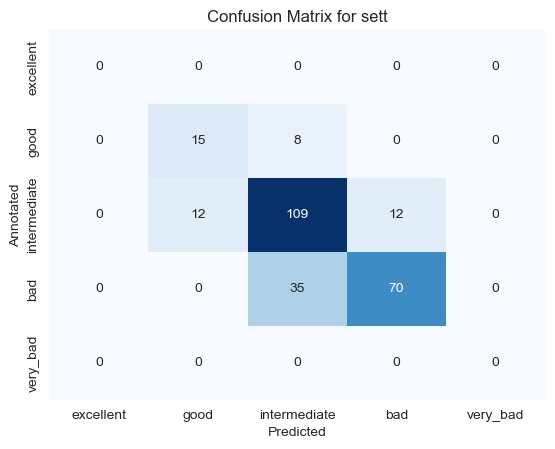

<Figure size 640x480 with 0 Axes>

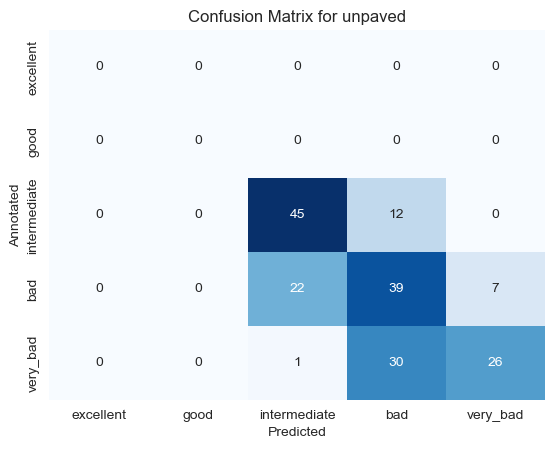

<Figure size 640x480 with 0 Axes>

In [104]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
for surface in df_valid_quality.type_true.unique():
    _df = df_valid_quality[(df_valid_quality.type_true == surface)]
    cm = confusion_matrix(_df.quality_true, _df.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
                yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.title(f"Confusion Matrix for {surface}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()



In [99]:
# Extract predicted and ground truth values
precisions = []
recalls = []
f1scores = []
for class_name in df_valid_type['type_true'].unique():
    _df1 = df_valid_type[df_valid_type['type_pred'] == class_name]
    _df2 = df_valid_type[df_valid_type['type_true'] == class_name]
    class_precision = sum(_df1.type_true == class_name) / len(_df1)
    class_recall = sum(_df2.type_pred == class_name) / len(_df2)
    f1score = 2 * (class_precision * class_recall) / (class_precision + class_recall)
    precisions.append(class_precision)
    recalls.append(class_recall)
    f1scores.append(f1score)

    print(f"Class: {class_name}")t
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")

print("------------------------")
print("------------------------")

print(f"Average precision: {round(np.mean(precisions), 2)}")
print(f"Average recall: {round(np.mean(recalls), 2)}")
print(f"Average F1-Score: {round(np.mean(f1scores), 2)}")
print(f"Accuracy: {round(sum(df_valid_type.type_true == df_valid_type.type_pred) / len(df_valid_type), 2)}")

Class: asphalt
Count (pred): 631
Count (true): 641
Precision: 0.95
Recall: 0.93
------------------------
Class: concrete
Count (pred): 205
Count (true): 191
Precision: 0.8
Recall: 0.85
------------------------
Class: sett
Count (pred): 267
Count (true): 267
Precision: 0.96
Recall: 0.96
------------------------
Class: paving_stones
Count (pred): 375
Count (true): 385
Precision: 0.98
Recall: 0.95
------------------------
Class: unpaved
Count (pred): 192
Count (true): 186
Precision: 0.94
Recall: 0.97
------------------------
------------------------
------------------------
Average precision: 0.92
Average recall: 0.93
Average F1-Score: 0.93
Accuracy: 0.94
